## Import the basics

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from random import randint
import utils as ut 
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms


#from util import get_normalized_data

from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf




AttributeError: module 'tensorflow' has no attribute 'GraphKeys'

## Use GPU with cuda

In [7]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)



cuda


## Test case on CIFAR-10

In [3]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())
print(train_data.type())
print(test_data.type())


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.FloatTensor
torch.FloatTensor


In [4]:
train_data_2 = F.interpolate(train_data, scale_factor=2)
print(train_data_2.size())

torch.Size([50000, 3, 64, 64])


In [5]:
mean= train_data.mean()

print(mean)

std= train_data.std()

print(std)


tensor(0.4734)
tensor(0.2516)


# Model 


In [6]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x


In [7]:
net=VGG_convnet()

print(net)
ut.display_num_param(net)


VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [8]:
net = net.to(device)

mean = mean.to(device)

std = std.to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 128

## Train and Test the model

In [10]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data

        scores=net( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    #print( 'error rate on test set =', total_error*100 ,'percent')
    accuracy = 1-total_error
    print('accuracy on test set =', accuracy*100, '%')


# ### Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

# In[11]:


start=time.time()

for epoch in range(1,40):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 20 or epoch==30 or epoch==35:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
      

epoch= 1 	 time= 1.8182127078374226 min 	 lr= 0.25 	 loss= 2.3031698773279214 	 error= 89.94205562050081 percent
accuracy on test set = 10.096914556962023 %
 
epoch= 2 	 time= 3.7086350599924724 min 	 lr= 0.25 	 loss= 2.301162473381023 	 error= 89.52325766958545 percent
accuracy on test set = 9.889240506329111 %
 
epoch= 3 	 time= 5.583593503634135 min 	 lr= 0.25 	 loss= 2.3026106327086153 	 error= 89.71027812689466 percent
accuracy on test set = 10.096914556962023 %
 
epoch= 4 	 time= 7.448767550786337 min 	 lr= 0.25 	 loss= 2.301766462643128 	 error= 89.6699168797954 percent
accuracy on test set = 10.096914556962023 %
 
epoch= 5 	 time= 9.313446040948232 min 	 lr= 0.25 	 loss= 2.3032280136557186 	 error= 90.15025575752453 percent
accuracy on test set = 9.958465189873422 %
 
epoch= 6 	 time= 11.181481687227885 min 	 lr= 0.25 	 loss= 2.3031343950335024 	 error= 90.11508952016416 percent
accuracy on test set = 9.889240506329111 %
 
epoch= 7 	 time= 13.054163281122843 min 	 lr= 0.25 	 lo

## Playing with Pytorch and Tensorflow

In [11]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')




In [12]:
train = train_data[58]
print(train.size())
train = train.view(1,3,32,32)
print(train.size())

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [13]:
print(train_data.size())
print(train_label[58].size())

torch.Size([50000, 3, 32, 32])
torch.Size([])


In [14]:
label = train_label[[58]]

In [15]:
print(label)

tensor([4])


In [16]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train, label))
sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')



## Adversarial attack: FSGM

In [17]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.04,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


## Check model performance after the attack

In [148]:
no_runs = 10000
correct = 0

dist_cifar_list = []
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    dist_cifar_list.append( max(np.reshape(np.array(adv_example-xs), 3072)))
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    


In [140]:
dist_cifar = np.array(dist_cifar_list)  
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack: {:.3f}'.format(acc * 100))

Adversarial accuracy with FGSM attack: 34.720


In [127]:
print(type(adv_example))

<class 'numpy.ndarray'>


In [128]:
adversarial = torch.from_numpy(adv_example)

In [129]:
print(adversarial.size())

torch.Size([1, 3, 32, 32])


## Examples

### Actual image

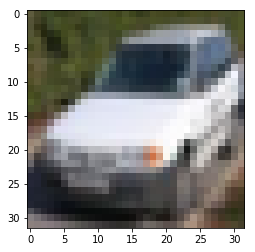

In [130]:
ut.show(train_data[46])

### Corresponding adversarial example

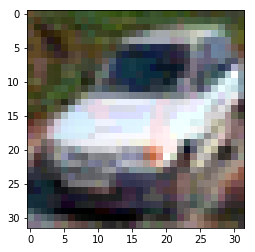

In [131]:
ut.show(adversarial[0])

In [132]:
diff = train_data[46]-adversarial[0]

In [141]:
print(diff)

tensor([[[-0.0400, -0.0400, -0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [ 0.0400, -0.0400, -0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [-0.0400,  0.0400, -0.0400,  ..., -0.0400, -0.0400,  0.0400],
         ...,
         [ 0.0400,  0.0400,  0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [ 0.0400,  0.0400,  0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [ 0.0400,  0.0400,  0.0400,  ..., -0.0400, -0.0400,  0.0400]],

        [[ 0.0400, -0.0400, -0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [ 0.0400,  0.0400, -0.0400,  ..., -0.0400,  0.0400,  0.0400],
         [ 0.0400,  0.0400,  0.0400,  ..., -0.0400, -0.0400,  0.0400],
         ...,
         [-0.0400, -0.0400, -0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [-0.0400,  0.0400, -0.0400,  ...,  0.0400,  0.0400,  0.0400],
         [ 0.0400,  0.0400, -0.0400,  ..., -0.0400, -0.0400,  0.0400]],

        [[ 0.0400, -0.0400, -0.0400,  ..., -0.0400, -0.0400, -0.0400],
         [ 0.0400,  0.0400, -0.0400,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


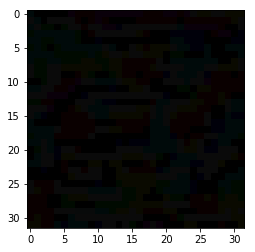

In [135]:
ut.show(diff)
#plt.imshow(diff)
#plt.show()

In [46]:

import matplotlib as plt


(array([  46.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9954.]),
 array([0.        , 0.03      , 0.06000001, 0.09000001, 0.12000002,
        0.15000002, 0.18000002, 0.21000002, 0.24000004, 0.27000004,
        0.30000004], dtype=float32),
 <a list of 10 Patch objects>)

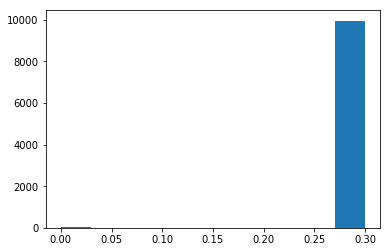

In [69]:
plt.pyplot.hist(dist_cifar)

In [73]:
print(np.std(dist_cifar))

0.020300144


In [27]:
from cleverhans.attacks import *

## Adversarial attack: Momentum Iterative

In [29]:
mi_op = MomentumIterativeMethod(cleverhans_model, sess=sess)

mi_params = { 'eps' : 0.3, 'eps_iter' : 0.06, 'nb_iter' : 10} #'y': None, 'ord' : inf, 'decay_factor' : 1.0, 'clip_min' : None, 'clip_max' : None, 'y_target' : None}

adv_x_op = mi_op.generate(x_op1, **mi_params)
adv_preds_op = tf_net(adv_x_op)

no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()

acc = float(correct) / no_runs

print('Adversarial accuracy with MomentumIterative method attack: {:.3f}'.format(acc * 100))



c:\users\hesl\ce7454_2018\cleverhans\cleverhans\attacks.py:34: UserWarning: Argument back to attack constructors is not needed anymore and will be removed on or after 2019-03-26. All attacks are implemented using TensorFlow.
  warnings.warn("Argument back to attack constructors is not needed"


Adversarial accuracy with MomentumIterative method attack: 15.720


## Change dataset to MNIST

In [149]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

In [150]:
class two_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(two_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size  , output_size   , bias=False  )
        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        scores  = self.layer2(y_hat)
        
        return scores

In [151]:
net_basic=two_layer_net(784,50,10)

print(net_basic)
ut.display_num_param(net_basic)

two_layer_net(
  (layer1): Linear(in_features=784, out_features=50, bias=False)
  (layer2): Linear(in_features=50, out_features=10, bias=False)
)
There are 39700 (0.04 million) parameters in this neural network


In [ ]:
from pytorch_modelsize import SizeEstimator

se = SizeEstimator(model, input_size=(784,50,10))
print(se.estimate_size())


In [152]:
criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.Adam( net_basic.parameters() , lr=0.01 )

bs=20

In [153]:
net_basic = net_basic.to(device)
print(device)

cuda


In [154]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label= test_label[i:i+bs].to(device)

        inputs = minibatch_data.view(bs,784)

        scores=net_basic( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

## Train and test the model

In [155]:
start = time.time()

for epoch in range(30):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].to(device)
        minibatch_label= train_label[indices].to(device)

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net_basic( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 5 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, '\t time=', elapsed_time,
              '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
        eval_on_test_set()
               

 
epoch= 0 	 time= 10.685914993286133 	 loss= 0.27820682751519293 	 error= 8.106665792067846 percent
test error  =  5.80999939441681 percent
 
epoch= 5 	 time= 64.25322961807251 	 loss= 0.15204911037259203 	 error= 3.849999902645747 percent
test error  =  4.949999475479126 percent
 
epoch= 10 	 time= 118.60045742988586 	 loss= 0.1322210292347677 	 error= 3.3366666078567504 percent
test error  =  4.65999960899353 percent
 
epoch= 15 	 time= 173.11955618858337 	 loss= 0.12170427537780901 	 error= 2.994999974966049 percent
test error  =  4.249999594688416 percent
 
epoch= 20 	 time= 228.89564561843872 	 loss= 0.1138219058794327 	 error= 2.6733333647251127 percent
test error  =  3.8399998903274537 percent
 
epoch= 25 	 time= 284.5814998149872 	 loss= 0.10506286737662096 	 error= 2.4816667040189104 percent
test error  =  4.699999582767487 percent


In [187]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data.view(60000,784), train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data.view(10000,784), test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,784,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net_basic)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')


In [200]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.1,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


In [170]:
train = train_data[58]
train = train.view(1,784)
label = train_label[[58]]

In [171]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train, label))
sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,784,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')


In [201]:
no_runs = 10000
correct = 0

dist_mnist_list = []
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    dist_mnist_list.append( max(np.reshape(np.array(adv_example-xs), 784)))
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    

In [139]:
dist_mnist = np.array(dist_mnist_list)  
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack for MNIST: {:.3f}'.format(acc * 100))

Adversarial accuracy with FGSM attack for MNIST: 55.860


In [176]:
import matplotlib as plt

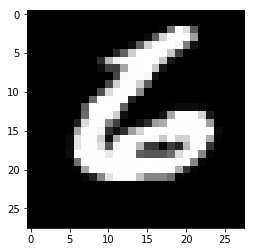

In [193]:
ut.show(test_data[9999])

In [202]:
adversarial = torch.from_numpy(adv_example)
adversarial = adversarial.view(1,28,28)
print(adversarial.size())


torch.Size([1, 28, 28])


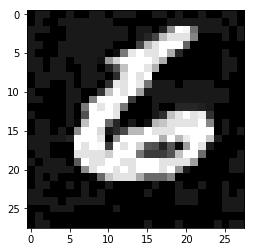

In [203]:
ut.show(adversarial[0])

In [204]:
diff = test_data[9999]-adversarial[0]

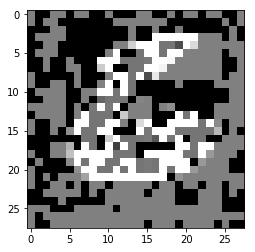

In [205]:
ut.show(diff)

(array([2869.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7131.]),
 array([0.        , 0.03      , 0.06000001, 0.09000001, 0.12000002,
        0.15000002, 0.18000002, 0.21000002, 0.24000004, 0.27000004,
        0.30000004], dtype=float32),
 <a list of 10 Patch objects>)

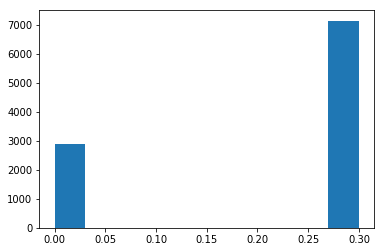

In [141]:
plt.pyplot.hist(dist_mnist)

In [142]:
print(max (dist_mnist))

0.30000004


In [143]:
mi_op = MomentumIterativeMethod(cleverhans_model, sess=sess)

mi_params = { 'eps' : 0.3, 'eps_iter' : 0.06, 'nb_iter' : 10} #'y': None, 'ord' : inf, 'decay_factor' : 1.0, 'clip_min' : None, 'clip_max' : None, 'y_target' : None}

adv_x_op = mi_op.generate(x_op1, **mi_params)
adv_preds_op = tf_net(adv_x_op)

no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()

acc = float(correct) / no_runs

print('Adversarial accuracy with MomentumIterative method attack on MNIST: {:.3f}'.format(acc * 100))



Adversarial accuracy with MomentumIterative method attack on MNIST: 50.060
